In [2]:
import numpy as np

import os as os
import warnings

os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable

import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt

from numpy.linalg import inv
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import odeint
from scipy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy import integrate

import ipywidgets as ipw

In [3]:
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
RANDOM_SEED = 123446
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [5]:
# Checking versions
print(f"Theano version: {theano.__version__}")
print(f"PyMC3 version: {pm.__version__}")

Theano version: 1.1.2
PyMC3 version: 3.11.4


Utility code for defining a random process

In [6]:
class SquaredExponential:
    def __init__(self, coords, mkl, lamb):
        """
        This class sets up a random process
        on a grid and generates
        a realisation of the process, given
        parameters or a random vector.
        """

        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.coords = np.reshape(self.coords,(len(self.coords),1))
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb

        self.assemble_covariance_matrix()

    def assemble_covariance_matrix(self):
        """
        Create a snazzy distance-matrix for rapid
        computation of the covariance matrix.
        """
        dist = distance_matrix(self.coords, self.coords)

        # Compute the covariance between all
        # points in the space.
        self.cov = np.exp(-0.5 * dist ** 2 / self.lamb ** 2)

    def plot_covariance_matrix(self):
        """
        Plot the covariance matrix.
        """
        plt.figure(figsize=(10, 8))
        plt.imshow(self.cov, cmap="binary")
        plt.colorbar()
        plt.show()

    def compute_eigenpairs(self):
        """
        Find eigenvalues and eigenvectors using Arnoldi iteration.
        """
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))

        order = np.flip(np.argsort(eigvals))
        self.eigenvalues = eigvals[order]
        self.eigenvectors = eigvecs[:, order]

    def generate(self, parameters=None):
        """
        Generate a random field, see
        Scarth, C., Adhikari, S., Cabral, P. H.,
        Silva, G. H. C., & Prado, A. P. do. (2019).
        Random field simulation over curved surfaces:
        Applications to computational structural mechanics.
        Computer Methods in Applied Mechanics and Engineering,
        345, 283–301. https://doi.org/10.1016/j.cma.2018.10.026
        """

        if parameters is None:
            self.parameters = np.random.normal(size=self.mkl)
        else:
            self.parameters = np.array(parameters).flatten()

        self.random_field = np.linalg.multi_dot(
            (self.eigenvectors, np.sqrt(np.diag(self.eigenvalues)), self.parameters)
        )

    def plot(self, lognormal=True):
        """
        Plot the random field.
        """

        if lognormal:
            random_field = self.random_field
            contour_levels = np.linspace(min(random_field), max(random_field), 20)
        else:
            random_field = np.exp(self.random_field)
            contour_levels = np.linspace(min(random_field), max(random_field), 20)

        plt.figure(figsize=(12, 10))
        plt.tricontourf(
            self.coords[:, 0],
            self.coords[:, 1],
            random_field,
            levels=contour_levels,
            cmap="plasma",
        )
        plt.colorbar()
        plt.show()


class Matern52(SquaredExponential):
    def assemble_covariance_matrix(self):
        """
        This class inherits from RandomProcess and creates a Matern 5/2 covariance matrix.
        """

        # Compute scaled distances.
        dist = np.sqrt(5) * distance_matrix(self.coords, self.coords) / self.lamb

        # Set up Matern 5/2 covariance matrix.
        self.cov = (1 + dist + dist ** 2 / 3) * np.exp(-dist)

--------------------------------------------------------------------------------
# LOTKA - VOLTERRA PROBLEM

--------------------------------------------------------------------------------
Let $$
X:=
\left[\begin{array}{c}
  x_1 \\ 
  x_2
\end{array}\right]
$$

The predator-prey dynamical system is governed by the ODE

$$
\dot{X}=\left[\begin{array}{c}\frac{dx_1}{dt} \\ \frac{dx_2}{dt}
\end{array}\right]=f(X)
$$
where
$$
f(X)=\left[\begin{array}{c}x_1(\gamma_1-\gamma_{12}x_2) \\ x_2(-\gamma_2+\gamma_{21}x_1)
\end{array}\right].
$$

# Model definition and data generation

In [7]:
# Set the model parameters.
depth = 0.1
T_max = 30
n_data = 1000
gamma_1=1
gamma_12=1
gamma_21=1
gamma_2=1
X_0=[4,2]

# noise level
noise_level = 0.05

# Set random process parameters.
lamb = 0.1
mkl = 14

# Set the quadrature degree for each model level (coarsest first)
n_quadrature = [250, 1000]

In [8]:
class LotkaVolterra:
  def __init__(self,f_function,X_0,T_max,n_data,gamma_1, gamma_12, gamma_2, gamma_21):
        
        # Set the function describing the dynamics of the predator and prey populations.
        self.f_function = f_function

        # Set the rate parameters
        self.gamma_1=gamma_1
        self.gamma_12=gamma_12
        self.gamma_2=gamma_2
        self.gamma_21=gamma_21

        # Set the grid length along time dimension.
        self.T_max = T_max

        # Set the number of data points along one dimension
        self.n_data = n_data

        # Set initial condition
        self.X_0=X_0

        # Set the quadrature points.
        t = np.linspace(0, T_max, self.n_data + 1)
        self.tt = (t[1:] + t[:-1]) / 2

        #Calculate the solution by means of odeint
        self.X=integrate.odeint(self.f_function, self.X_0, self.tt, args = (gamma_1, gamma_12, gamma_2, gamma_21))
    
  def plot_model(self):
        plt.figure()
        plt.grid()
        plt.title("Populations of predator and prey")
        plt.plot(self.tt, self.X[:,0], 'xb', label = 'Deer')
        plt.plot(self.tt, self.X[:,-1], '+r', label = "Wolves")
        plt.xlabel('Time t, [days]')
        plt.ylabel('Population')
        plt.legend()
        plt.show()





In [9]:

def f(X, t, gamma_1, gamma_12, gamma_2, gamma_21):
    x1, x2 = X
    dotx1 = x1 * (gamma_1 - gamma_12 * x2)
    dotx2 = x2 * (-gamma_2 + gamma_21 * x1)
    return np.array([dotx1, dotx2])

In [15]:
true_model=LotkaVolterra(f,X_0,T_max,n_data,gamma_1, gamma_12, gamma_2, gamma_21)


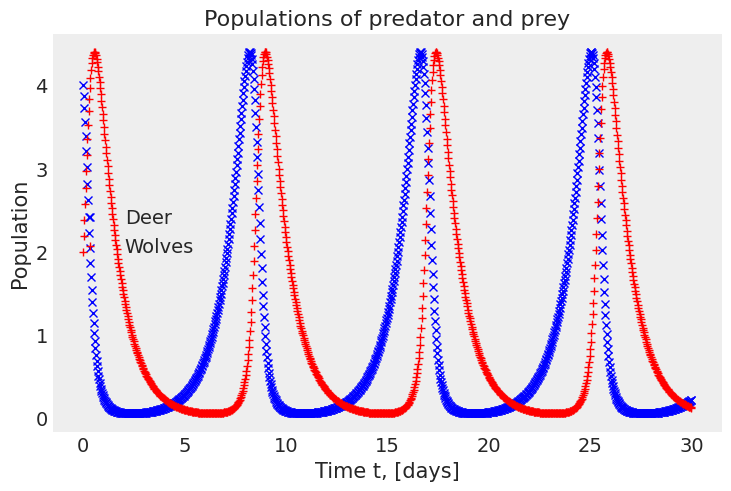

In [16]:
true_model.plot_model()

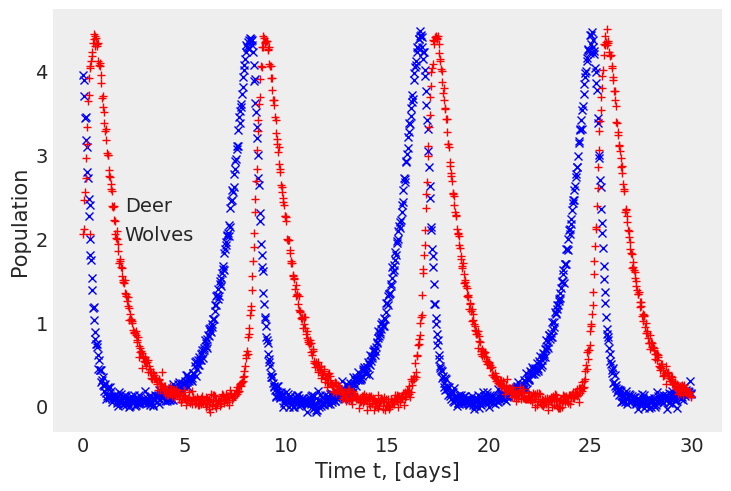

In [17]:
np.random.seed(123)
noise = np.random.normal(0, noise_level, [n_data,2])
data = true_model.X + noise

plt.figure()
plt.grid()
plt.plot(true_model.tt,data[:,0],'xb', label = 'Deer')
plt.plot(true_model.tt,data[:,-1],'+r', label = "Wolves")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()
plt.show()

# Implementing the model, and defining coarse and fine models

In [18]:
class LotkaVolterra_Forward(LotkaVolterra):
  def __init__(self,X_0,T_max,n_data,gamma_1, gamma_12, gamma_2, gamma_21):
      # Set the rate parameters
      self.gamma_1=gamma_1
      self.gamma_12=gamma_12
      self.gamma_2=gamma_2
      self.gamma_21=gamma_21

      # Set the grid length along time dimension.
      self.T_max = T_max

      # Set the number of data points along one dimension
      self.n_data = n_data

      # Set initial condition
      self.X_0=X_0

      # Set the quadrature points.
      t = np.linspace(0, T_max, self.n_data + 1)
      self.tt = (t[1:] + t[:-1]) / 2

  def set_random_process(self, random_process, lamb, mkl):
      # Set the number of KL modes.
      self.mkl = mkl

      # Initialise a random process on the quadrature points.
      # and compute the eigenpairs of the covariance matrix,
      self.random_process = random_process(self.tt, self.mkl, lamb)
      self.random_process.compute_eigenpairs()

      
  
  
  def solve(self, parameters):
    
      # Internalise the Random Field parameters
      self.parameters=parameters

      # Create a realisation of the random process, given the parameters.
      self.random_process.generate(self.parameters)
      mean = 0.0
      stdev = 1.0

      # Set the density.
      self.f = mean + stdev * self.random_process.random_field
      
      # Compute the solution X by means of Forward Euler. No idea what i'm doing here
      self.X=np.empty((len(self.f),2))
      self.X[0,:]=X_0
      for i in range(1,len(self.f)):
        self.X[i,:]=self.X[i-1,:] + (T_max/n_data)*np.array([self.f[i-1],self.f[i-1]])


  def get_data(self):

      # Get the data vector.
      return self.X

# --------------- TASK ------------------------------ (Solved?)
# We have to find a way to calculate X based on the gaussian process realization f...
# Since f is a vector of n_data components, we cannot use odeint() directly.

# Suggestion: Can we just run a for-loop, and do forward euler, where each new step
# is the previous step plus the product of stepsize h and a component of f?
# Since X is 2D, do we need two different GP since f is 1D?
      
      

[7.94996879 7.94841417 7.94582403 7.94219973 7.93754314 7.93185669
 7.92514334 7.91740657 7.90865038 7.8988793  7.88809839 7.87631319
 7.86352978 7.84975471]


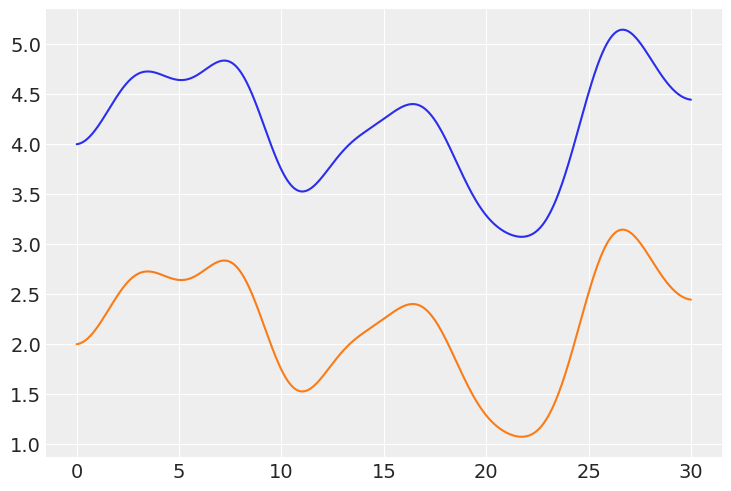

In [22]:
Forward_model=LotkaVolterra_Forward(X_0,T_max,n_data,gamma_1,gamma_12,gamma_2,gamma_21)
Forward_model.set_random_process(Matern52,lamb,mkl)
Forward_model.solve(None)
X=Forward_model.get_data()


# These are the GPs that are supposed to mimic Lotka-Volterra, obviously totally
# non-informative "priors" for f(X). We are going to incorporate the generated data
# from before and these GP's in order to formulate a likelihood.
plt.plot(np.linspace(0,30,1000),X[:,0])
plt.plot(np.linspace(0,30,1000),X[:,1])
plt.show()



In [20]:
# We project the eigenmodes of the fine model to the quadrature points
# of the coarse model using linear interpolation.
def project_eigenmodes(model_coarse, model_fine):
    model_coarse.random_process.eigenvalues = model_fine.random_process.eigenvalues
    for i in range(model_coarse.mkl):
        interpolator = RectBivariateSpline(
            model_fine.tx,
            model_fine.ty,
            model_fine.random_process.eigenvectors[:, i].reshape(
                model_fine.n_quad, model_fine.n_quad
            ),
        )
        model_coarse.random_process.eigenvectors[:, i] = interpolator(
            model_coarse.tx, model_coarse.ty
        ).ravel()


# --------------- TASK ------------------
# We must find a way to do this interpolation in 1D instead of 2D


In [21]:
# Initialise the models, according the quadrature degree.
my_models = []
for i, n_data in enumerate(n_quadrature):
    my_models.append(LotkaVolterra_Forward(X_0,T_max,n_data,gamma_1,gamma_12,gamma_2,gamma_21))
    my_models[i].set_random_process(Matern52, lamb, mkl)

# Project the eigenmodes of the fine model to the coarse model.
for m in my_models[:-1]:
    project_eigenmodes(m, my_models[-1])

AttributeError: ignored

-------------- EVERYTHING BELOW IS NOT PART OF THE PROJECT ---------------------


-------------------------------------------------------------------------------
PENDEL PROBLEM

-------------------------------------------------------------------------------

In [ ]:


def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5.0

y0 = [np.pi - 0.1, 0.0]

t = np.linspace(0, 10, 101)
t_coarse=t[::3]

In [ ]:
#Simulated data with noise
size=(len(t),2)
size_coarse=(len(t_coarse),2)
sigma=0.5
sol = odeint(pend, y0, t, args=(b, c))+np.random.normal(0, sigma ** 2, size)
sol_coarse=odeint(pend, y0, t_coarse, args=(b, c))+np.random.normal(0, sigma ** 2, size_coarse)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], 'bo', label='theta(t)')
plt.plot(t, sol[:, 1], 'go', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

plt.title("Coarse data")
plt.plot(t_coarse, sol_coarse[:, 0], 'bo', label='theta(t)')
plt.plot(t_coarse, sol_coarse[:, 1], 'go', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

Notes \\
Theano op: we use these when a library does not have the function that we are looking for, and we have to create it ourselves. A selfmade Op would normally consist of combinations of already existing ops, and is normally short and bug free.
In the gravity surveying example they use it since they have to define new input and output types, vector and scalar respectively.

Log-likelihood of gaussian process: defined in an op, which we use in the coarse and fine model.

Data= "observations" from somewhere, that we generate from a true model, the one that we want to make inference on ("we dont know it") \\
Output= the "data" or solutions we get from solving the equation (i.e. compute the signal) where the mass distribution is modeled as a random gaussian process.

Roadmap: \\
Define a numerical scheme for our ODE, and model the solution as a gaussian process
Compute likelihoods at all levels with help from the 
